<a href="https://colab.research.google.com/github/Ping-Hung/570-Project/blob/main/570_ViT_Reimplement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import MNIST Dataset (What this project will be trained and tested on)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define Transform Util which Includes Normalization

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


# Loading Dataset

In [ ]:
# Load the training and test datasets
train_dataset = datasets.MNIST(root='./sample_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./sample_data', train=False, transform=transform, download=True)

# Define data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]


Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.68MB/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



# Check a Sample Batch to Verify Successful Load



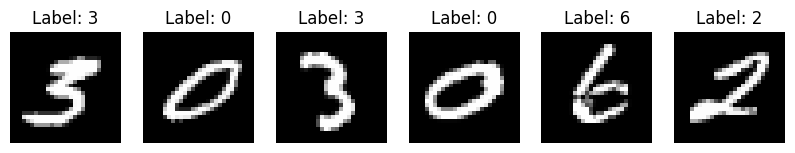

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the first 6 images in the batch
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()


# Re-Building the Transformer

In [ ]:
# import modules needed
import numpy as np
from tqdm import tqdm, trange
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


# Define own VIT module

In [ ]:
# helper (using positional embedding in Assignment 4)
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
          if j % 2 == 0:
            result[i][j] = np.sin(i / (10000 ** (j / d)))
          else:
             np.cos(i / (10000 ** (j / d)))
    return result

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

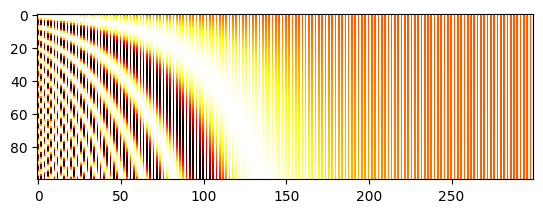

In [ ]:
# test the helper by plotting out
import matplotlib.pyplot as plt

plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

# Multi-Head Self Attention

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Should ensure dimension {d} can be divided into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
      # Sequences has shape (N, seq_length, token_dim)
      # first go into shape    (N, seq_length, n_heads, token_dim / n_heads)
      # then come back to    (N, seq_length, item_dim)  (through concatenation)
      result = []
      for sequence in sequences:
          seq_result = []
          for head in range(self.n_heads):
              q_mapping = self.q_mappings[head]
              k_mapping = self.k_mappings[head]
              v_mapping = self.v_mappings[head]

              seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
              q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

              attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
              seq_result.append(attention @ v)
          result.append(torch.hstack(seq_result))
      return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


# Encoder Block

In [ ]:
class ViTEncoderBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTEncoderBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MultiHeadSelfAttention(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


# Main VIT Class

In [ ]:
class VIT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
      # Super constructor
      super(VIT, self).__init__()

      # Attributes
      self.chw = chw # ( C , H , W )
      self.n_patches = n_patches
      self.n_blocks = n_blocks
      self.n_heads = n_heads
      self.hidden_d = hidden_d

      # Input and patches sizes
      assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
      assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
      self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

      # 1) Linear mapper
      self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
      self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

      # 2) Learnable classification token
      self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

      # 3) Positional embedding
      self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

      # 4) Transformer encoder blocks
      self.blocks = nn.ModuleList([ViTEncoderBlock(hidden_d, n_heads) for _ in range(n_blocks)])

      # 5) Classification MLPk
      self.mlp = nn.Sequential(
          nn.Linear(self.hidden_d, out_d),
          nn.Softmax(dim=-1)
      )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

# Test/Eval Scripts for the Model

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = VIT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 10
LR = 0.005

# Training loop

optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

batch_loss = []

for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        batch_loss.append(loss.item())
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Using device:  cuda (NVIDIA A100-SXM4-40GB)


Training:  10%|█         | 1/10 [05:58<53:50, 358.96s/it]

Epoch 1/10 loss: 2.02



Training:  20%|██        | 2/10 [11:57<47:48, 358.52s/it]

Epoch 2/10 loss: 1.84



Training:  30%|███       | 3/10 [17:55<41:49, 358.56s/it]

Epoch 3/10 loss: 1.79



Training:  40%|████      | 4/10 [23:54<35:50, 358.49s/it]

Epoch 4/10 loss: 1.76



Training:  50%|█████     | 5/10 [29:52<29:51, 358.32s/it]

Epoch 5/10 loss: 1.74



Training:  60%|██████    | 6/10 [35:50<23:53, 358.38s/it]

Epoch 6/10 loss: 1.73



Training:  70%|███████   | 7/10 [41:48<17:55, 358.35s/it]

Epoch 7/10 loss: 1.72



Training:  80%|████████  | 8/10 [47:48<11:57, 358.59s/it]

Epoch 8/10 loss: 1.71



Training:  90%|█████████ | 9/10 [53:45<05:58, 358.27s/it]

Epoch 9/10 loss: 1.69



Epoch 10 in training:  88%|████████▊ | 825/938 [05:15<00:43,  2.61it/s]

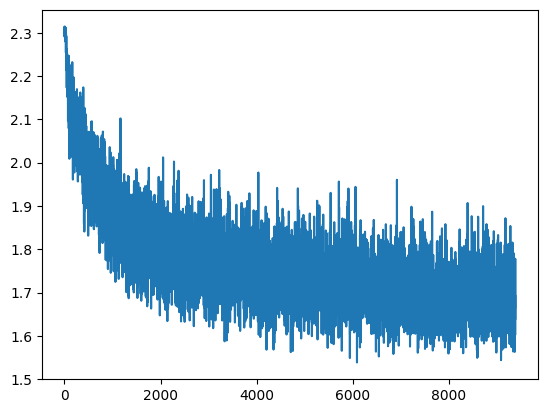

In [14]:
# plot batch loss
plt.plot(batch_loss)
plt.show()

In [15]:
Epoch_loss = []
for i in range(N_EPOCHS):
  Epoch_loss.append(sum(batch_loss[i*len(train_loader):(i+1)*len(train_loader)])/len(train_loader))

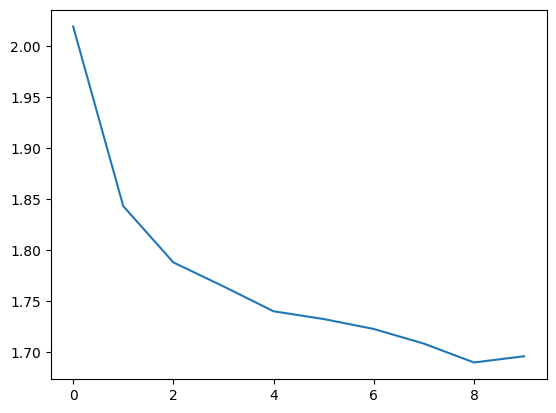

In [16]:
# plot epoch loss
plt.plot(Epoch_loss)
plt.show()

In [17]:
print(Epoch_loss[-1])

1.6956103056478602


In [ ]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")
